In [1]:
from time import time, process_time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from utility import *
from LSTM import *

homedir = get_homedir()

In [2]:
FIPS_mapping, FIPS_full = get_FIPS(reduced=True)

## Load Datasets

In [3]:
import json

with open(f'{homedir}/JK/po_code_state_map.json') as f:
    po_st = json.load(f)

st_to_fips = {}
for dic in po_st:
    st_to_fips[dic['state']] = dic['fips']
st_to_fips['California']    

'06'

In [4]:
demo = pd.read_csv(f'{homedir}/JK/preprocessing/0510/demographic.csv')
demo.loc[:, 'fips'] = demo['fips'].apply(correct_FIPS)
demo.head()

,fips,PopRatioMale2017,PopRatio65+2017,PopulationDensityperSqMile2010,"MedicareEnrollment,AgedTot2017",#Hospitals,#ICU_beds,PopRatioMale<52010,PopRatio<52010,PopRatioMale5-92010,...,PopRatioMale65-742010,PopRatio65-742010,PopRatioMale75-842010,PopRatio75-842010,PopRatioMale>842010,PopRatio>842010,HeartDiseaseMortality,StrokeMortality,DiabetesPercentage,Smokers_Percentage
0,01001,0.486578,0.151196,91.8,0.144963,0.360334,1.081003,0.521375,0.033619,0.501378,...,0.453775,0.032808,0.424319,0.015152,0.288566,0.002865,204.5,56.1,9.9,18.081557
1,01003,0.485472,0.199470,114.7,0.195600,0.282183,2.398555,0.503137,0.026403,0.502802,...,0.480705,0.040249,0.459400,0.020595,0.363749,0.005531,183.2,41.9,8.5,17.489033
2,01005,0.527701,0.188247,31.0,0.186229,0.791452,1.978631,0.497650,0.033518,0.503045,...,0.476765,0.042224,0.405537,0.019707,0.291196,0.005105,220.4,49.0,15.7,21.999985
3,01007,0.535469,0.160226,36.8,0.149506,0.882301,0.000000,0.516691,0.031410,0.540214,...,0.466048,0.035424,0.409292,0.016323,0.261649,0.003220,225.5,57.2,13.3,19.114200
4,01009,0.493114,0.178426,88.9,0.164480,0.344750,1.034251,0.499170,0.031114,0.498969,...,0.470762,0.041215,0.431818,0.018996,0.289604,0.004034,224.8,52.8,14.9,19.208672


In [5]:
motality = pd.read_csv(f'{homedir}/JK/preprocessing/0510/motality.csv', parse_dates=['date'])
motality.loc[:, 'fips'] = motality['fips'].apply(correct_FIPS)
motality.head()

,date,fips,cases,deaths
0,2020-01-21,53061,1,0
1,2020-01-22,53061,1,0
2,2020-01-23,53061,1,0
3,2020-01-24,17031,1,0
4,2020-01-24,53061,1,0


In [6]:
mobility = pd.read_csv(f'{homedir}/JK/preprocessing/0510/mobility.csv', parse_dates=['date'])
mobility.loc[:, 'fips'] = mobility['fips'].apply(correct_FIPS)
mobility.head()

,date,fips,m50,m50_index
0,2020-03-01,01001,7.194,49
1,2020-03-01,01003,9.780,81
2,2020-03-01,01005,8.348,90
3,2020-03-01,01007,13.008,53
4,2020-03-01,01009,15.963,68


In [7]:
seasonality = pd.read_csv(f'{homedir}/exploratory_HJo/seasonality_stateLevel.csv', index_col=0, parse_dates=['date'])
seasonality['date'] += pd.Timedelta(days = 365*3)
seasonality.replace({'state':st_to_fips}, inplace=True)
seasonality.replace({'state':{'New York City':'36061'}}, inplace=True)
seasonality.head()

,state,date,seasonality
0,01,2020-01-01,0.292504
1,01,2020-01-02,0.309180
2,01,2020-01-03,0.325372
3,01,2020-01-04,0.340905
4,01,2020-01-05,0.355614


In [8]:
FIPS_demo = set(demo['fips']); FIPS_mt = set(motality['fips']); FIPS_mb = set(mobility['fips'])
print(len(FIPS_demo), len(FIPS_mt), len(FIPS_mb))

3114 2878 3172


In [9]:
date_st_mt = motality['date'].min(); date_ed_mt = motality['date'].max()
date_st_mb = mobility['date'].min(); date_ed_mb = mobility['date'].max()
print(date_st_mt, date_st_mb, date_ed_mt, date_ed_mb)

2020-01-21 00:00:00 2020-03-01 00:00:00 2020-05-08 00:00:00 2020-05-07 00:00:00


Two types of df: static, time-series
static df should be spanned by the timeline using np.kron

In [10]:
# settings
date_st = max(date_st_mt, date_st_mb); date_ed = pd.Timestamp('2020-05-02')#min(date_ed_mt, date_ed_mb)
date_win = pd.date_range(start=date_st, end=date_ed)
print('First date to be trained:', date_st, ', Final date to be trained:', date_ed)

columns_demo = list(demo.columns); columns_demo.remove('fips')
columns_mt = ['cases', 'deaths']
columns_mb = ['m50', 'm50_index']
columns_ss = ['seasonality']

First date to be trained: 2020-03-01 00:00:00 , Final date to be trained: 2020-05-02 00:00:00


In [11]:
columns_demo

['PopRatioMale2017',
 'PopRatio65+2017',
 'PopulationDensityperSqMile2010',
 'MedicareEnrollment,AgedTot2017',
 '#Hospitals',
 '#ICU_beds',
 'PopRatioMale<52010',
 'PopRatio<52010',
 'PopRatioMale5-92010',
 'PopRatio5-92010',
 'PopRatioMale10-142010',
 'PopRatio10-142010',
 'PopRatioMale15-192010',
 'PopRatio15-192010',
 'PopRatioMale20-242010',
 'PopRatio20-242010',
 'PopRatioMale25-292010',
 'PopRatio25-292010',
 'PopRatioMale30-342010',
 'PopRatio30-342010',
 'PopRatioMale35-442010',
 'PopRatio35-442010',
 'PopRatioMale45-542010',
 'PopRatio45-542010',
 'PopRatioMale55-592010',
 'PopRatio55-592010',
 'PopRatioMale60-642010',
 'PopRatio60-642010',
 'PopRatioMale65-742010',
 'PopRatio65-742010',
 'PopRatioMale75-842010',
 'PopRatio75-842010',
 'PopRatioMale>842010',
 'PopRatio>842010',
 'HeartDiseaseMortality',
 'StrokeMortality',
 'DiabetesPercentage',
 'Smokers_Percentage']

In [12]:
PATH_CLUSTER = f'{homedir}/JK/clustering/n_clusters=5_kmeans_extended.txt'

with open(PATH_CLUSTER, 'r') as f:
    classes = eval(f.read())

cluster_size = max(classes.values()) # missing values are ignored
FIPS_cluster = [set() for _ in range(cluster_size)]
for fips, i in classes.items():
    if i!=cluster_size:
        FIPS_cluster[i].add(fips)
for i in range(len(FIPS_cluster)):
    FIPS_cluster[i] = sorted(FIPS_cluster[i])
"""
Generate training data
in the order of demo-motal-mobi
"""
for c in range(len(FIPS_cluster)):
    dataList = []
    for fips in FIPS_cluster[c]:
        data1 = demo[demo['fips']==fips][columns_demo].to_numpy()
        data1 = np.repeat(data1, len(date_win), axis=0)
        
        data2 = motality[(motality['fips']==fips) & (motality['date'].isin(date_win))][['date']+columns_mt]
        _ = [[dt, 0, 0] for dt in date_win if dt not in list(data2['date'])]
        data2 = data2.append(pd.DataFrame(_, columns=['date']+columns_mt))
        data2 = data2.sort_values(by=['date'])[columns_mt].to_numpy()
        
        data3 = mobility[(mobility['fips']==fips) & (mobility['date'].isin(date_win))][['date']+columns_mb]
        data3 = data3.sort_values(by=['date'])[columns_mb].to_numpy()

        if fips == '36061':             # New York City
            data4 = seasonality[(seasonality['state']==fips) & (seasonality['date'].isin(date_win))][['date']+columns_ss]
        else:
            data4 = seasonality[(seasonality['state']==fips[:2]) & (seasonality['date'].isin(date_win))][['date']+columns_ss]
        data4 = data4.sort_values(by=['date'])[columns_ss].to_numpy()

        dataList.append(np.hstack((data1, data2, data3, data4)))
    np.save(f'{homedir}/JK/preprocessing/0509/dataList_cls={c}.npy', np.asarray(dataList, dtype=np.float64))
    with open(f'{homedir}/JK/preprocessing/0509/FIPS_cluster_cls={c}.txt', 'w') as f:
        print(FIPS_cluster[c], file=f)

## Split using clustering

In [9]:
FIPS_cluster = []
for c in range(5):
    with open(f'{homedir}/JK/preprocessing/0508/FIPS_cluster_cls={c}.txt', 'r') as f:
        FIPS_cluster.append(eval(f.read()))
FIPS_cluster[0][:5]

['06049', '08009', '08017', '08061', '08073']

In [21]:
dataList = [np.load(f'{homedir}/JK/preprocessing/0509/dataList_cls={c}.npy', allow_pickle=True) for c in range(5)]
dataList[1].shape

(1004, 63, 43)

In [11]:
history_size = 7
target_size = 14
step_size = 1
target_idx = (columns_demo+columns_mt+columns_mb).index('deaths')

X_train, y_train, X_val, y_val = train_val_split(dataList[0], target_idx, history_size, target_size, split_ratio=0.1, step_size=step_size)

In [12]:
scaler, *_ = get_StandardScaler(X_train)

X_train, y_train = normalizer(scaler, X_train, y_train, target_idx)
X_val, y_val = normalizer(scaler, X_val, y_val, target_idx)

In [13]:
train_data, val_data = load_Dataset(X_train, y_train, X_val, y_val)

In [14]:
model_qntl, history_qntl = LSTM_fit(train_data, val_data, lr=0.001, EPOCHS=5, monitor=True)

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 7s 37ms/step - loss: 0.1730 - val_loss: 0.2439
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 0.0692 - val_loss: 0.2439
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 0.0568 - val_loss: 0.2390
Epoch 4/5
200/200 [==============================] - 4s 21ms/step - loss: 0.0565 - val_loss: 0.2323
Epoch 5/5
200/200 [==============================] - 4s 20ms/step - loss: 0.0576 - val_loss: 0.2318
Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 7s 37ms/step - loss: 0.1417 - val_loss: 0.4590
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 0.1020 - val_loss: 0.4606
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 0.1113 - val_loss: 0.4530
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 0.0942 - val_loss: 0.4530
Epoch 5/5
200/

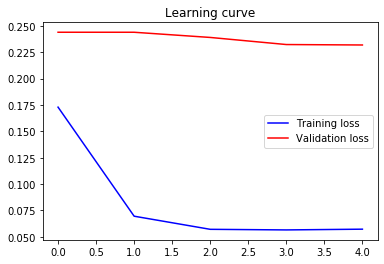

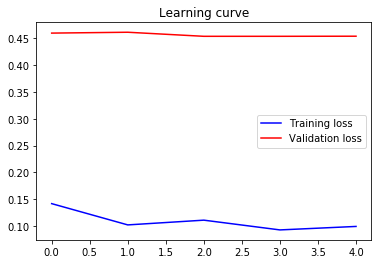

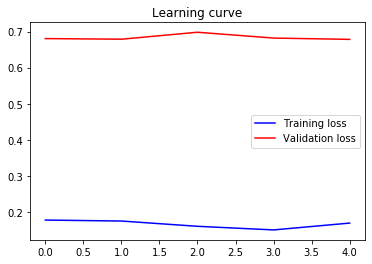

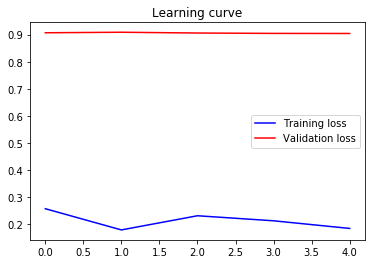

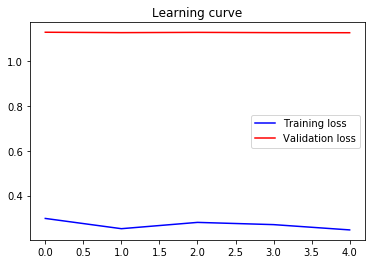

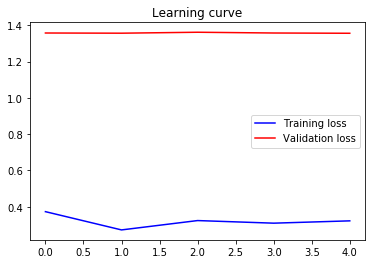

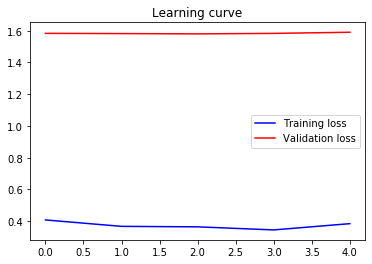

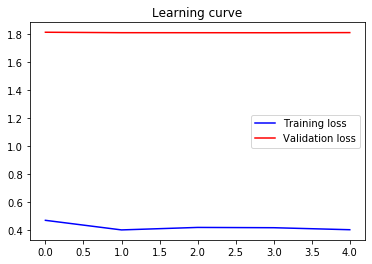

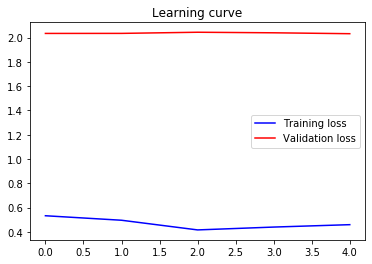

In [15]:
for history in history_qntl:
    plot_train_history(history, 'Learning curve')

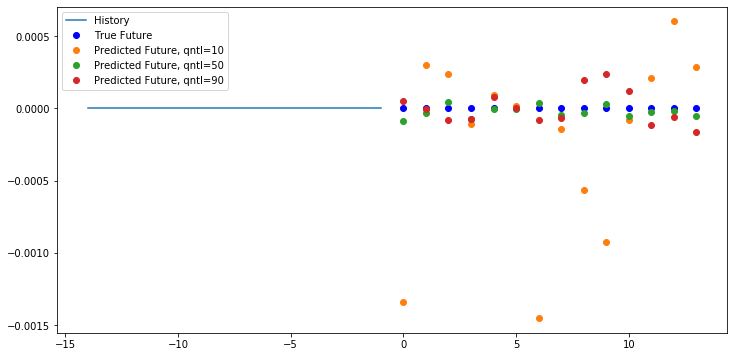

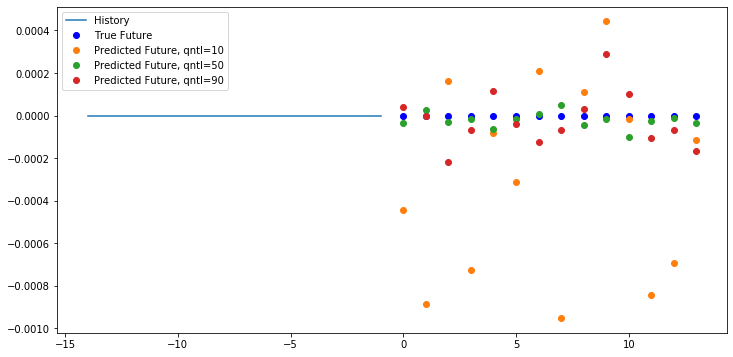

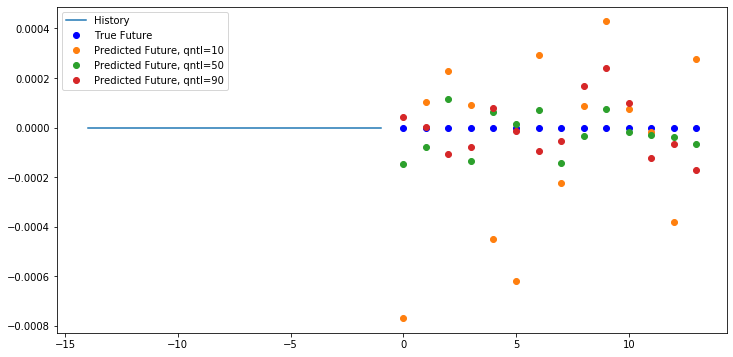

In [16]:
plot_prediction(model_qntl, val_data, scaler, target_idx)

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 8s 41ms/step - loss: 0.2674 - val_loss: 1.1280
Epoch 2/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2539 - val_loss: 1.1276
Epoch 3/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2735 - val_loss: 0.9958
Epoch 4/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2366 - val_loss: 2.4609
Epoch 5/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2361 - val_loss: 1.4234
Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 7s 36ms/step - loss: 0.2517 - val_loss: 1.1280
Epoch 2/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2621 - val_loss: 1.1280
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2662 - val_loss: 1.1280
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2455 - val_loss: 1.1280
Epoch 5/5
200/

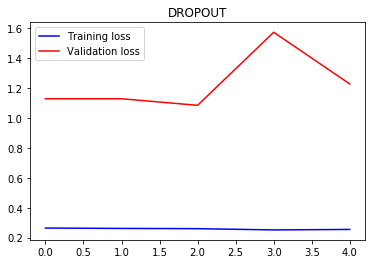

In [42]:
history_size = train_data.element_spec[0].shape[1]
feature_size = train_data.element_spec[0].shape[2]
target_size = train_data.element_spec[1].shape[1]
NUM_CELLS = 128
lr = 0.001
EPOCHS = 5
EVALUATION_INTERVAL = 200

quantile = 0.5

LOSS = np.zeros(EPOCHS)
VAL_LOSS = np.zeros(EPOCHS)

for n in range(3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(NUM_CELLS, return_sequences=True, input_shape=(history_size, feature_size)))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(round(NUM_CELLS/2), activation='relu', return_sequences=True, dropout=0.2))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(round(NUM_CELLS/4), activation='relu', dropout=0.2))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(target_size))

    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)
    LOSS += np.asarray(history.history['loss'])
    VAL_LOSS += np.asarray(history.history['val_loss'])

plt.figure()

plt.plot(range(EPOCHS), LOSS/3, 'b', label='Training loss')
plt.plot(range(EPOCHS), VAL_LOSS/3, 'r', label='Validation loss')
plt.title('DROPOUT')
plt.legend()

plt.show()

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 7s 36ms/step - loss: 0.3840 - val_loss: 1.1403
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2747 - val_loss: 1.1409
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2434 - val_loss: 1.1335
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2520 - val_loss: 1.1317
Epoch 5/5
200/200 [==============================] - 4s 20ms/step - loss: 0.2632 - val_loss: 1.1314
Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 10s 50ms/step - loss: 0.3813 - val_loss: 1.1347
Epoch 2/5
200/200 [==============================] - 5s 23ms/step - loss: 0.2616 - val_loss: 1.1384
Epoch 3/5
200/200 [==============================] - 5s 23ms/step - loss: 0.2514 - val_loss: 1.1408
Epoch 4/5
200/200 [==============================] - 5s 23ms/step - loss: 0.2609 - val_loss: 1.1322
Epoch 5/5
200

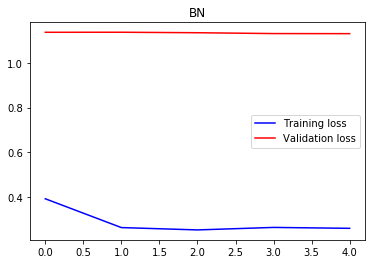

In [43]:
history_size = train_data.element_spec[0].shape[1]
feature_size = train_data.element_spec[0].shape[2]
target_size = train_data.element_spec[1].shape[1]
NUM_CELLS = 128
lr = 0.001
EPOCHS = 5
EVALUATION_INTERVAL = 200

quantile = 0.5

LOSS = np.zeros(EPOCHS)
VAL_LOSS = np.zeros(EPOCHS)

for n in range(3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(NUM_CELLS, return_sequences=True, input_shape=(history_size, feature_size)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(round(NUM_CELLS/2), activation='relu', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(round(NUM_CELLS/4), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(target_size))

    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)
    LOSS += np.asarray(history.history['loss'])
    VAL_LOSS += np.asarray(history.history['val_loss'])

plt.figure()

plt.plot(range(EPOCHS), LOSS/3, 'b', label='Training loss')
plt.plot(range(EPOCHS), VAL_LOSS/3, 'r', label='Validation loss')
plt.title('BN')
plt.legend()

plt.show()

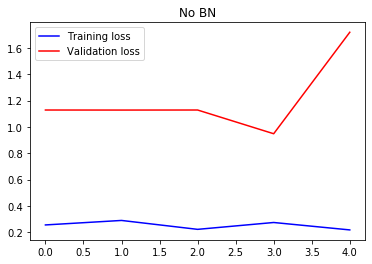

In [34]:
plot_train_history(history, 'No BN')

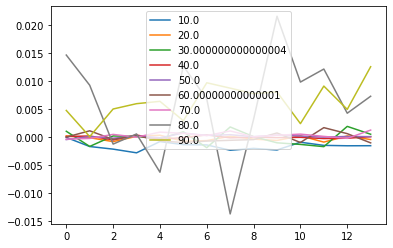

In [49]:
X_future = []

for data in dataList_norm:
    X_future.append(data[-history_size:, :])

X_future = np.asarray(X_future)

prediction_future = []
for i in range(len(model_qntl)):
    fips = 100
    prediction_future.append(scaler.scale_[target_idx]*model_qntl[i].predict(X_future)+scaler.mean_[target_idx])
prediction_future = np.asarray(prediction_future)

i = 100
for quantile in range(len(model_qntl)):
    plt.plot(range(14), prediction_future[quantile,i,:])

plt.legend((100*quantileList).tolist())
plt.show()

In [51]:
df_future = []
for i, fips in enumerate(FIPS_cluster[0]):
    for j in range(14):
        df_future.append([date_ed+pd.Timedelta(days=1+j), fips]+prediction_future[:,i,j].tolist())

df_future = pd.DataFrame(df_future, columns=['date', 'fips']+list(range(10, 100, 10)))
df_future.head()

,date,fips,10,20,30,40,50,60,70,80,90
0,2020-05-02,06049,0.000030,-0.000384,0.001150,0.000161,-0.000401,0.000337,-0.000401,0.001888,0.005650
1,2020-05-03,06049,-0.001836,-0.000065,-0.001531,-0.000617,0.001470,0.000739,0.001318,0.000498,0.000053
2,2020-05-04,06049,-0.002350,-0.000489,0.000057,0.000364,-0.000868,-0.000112,0.004175,0.001860,0.004694
3,2020-05-05,06049,-0.002669,-0.000372,-0.000017,-0.000366,-0.000833,-0.000051,0.000732,0.000656,0.005503
4,2020-05-06,06049,-0.000776,-0.000211,-0.000364,-0.000027,-0.002889,-0.000196,-0.000287,0.001239,0.006435


-----------------------------Train------------------------------------------

In [12]:
import itertools

target_idx = (columns_demo+columns_mt+columns_mb).index('deaths')
split_ratio = [0.1, 0.2]
QUANTILE = list(quantileList)
history_size = [7, 10, 14]
target_size = 14
step_size = 1
NUM_CELLS = [64, 128, 256]
lr = [0.0005, 0.001, 0.00146]
dropout = 0.2
EPOCHS = 10
EVALUATION_INTERVAL = 200

dict_folder = {'split_ratio':split_ratio, 'history_size':history_size}
keys, values = zip(*dict_folder.items())
permutations_folder = [dict(zip(keys, v)) for v in itertools.product(*values)]

dict_file = {'quantile':QUANTILE, 'NUM_CELLS':NUM_CELLS, 'lr':lr}
keys, values = zip(*dict_file.items())
permutations_file = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(len(permutations_folder))
print(len(permutations_file))

6
81


In [14]:
import os

for c in range(5):
    for perm_folder in permutations_folder:
        X_train, y_train, X_val, y_val = train_val_split(dataList[c], target_idx, perm_folder['history_size'], target_size, split_ratio=perm_folder['split_ratio'], step_size=step_size)

        scaler, *_ = get_StandardScaler(X_train)
        X_train, y_train = normalizer(scaler, X_train, y_train, target_idx)
        X_val, y_val = normalizer(scaler, X_val, y_val, target_idx)

        train_data, val_data = load_Dataset(X_train, y_train, X_val, y_val)

        PATH = f"{homedir}/JK/GridSearch/cls={c}_historysize={perm_folder['history_size']}_splt={perm_folder['split_ratio']}"
        try:
            os.mkdir(PATH)
        except OSError as error:
            pass

        history_size = train_data.element_spec[0].shape[1]
        feature_size = train_data.element_spec[0].shape[2]
        target_size = train_data.element_spec[1].shape[1]

        for perm_file in permutations_file:
            LOSS = np.zeros(EPOCHS)
            VAL_LOSS = np.zeros(EPOCHS)

            FILEPATH = f"/qntl={round(10*perm_file['quantile'])}_NUMCELL={perm_file['NUM_CELLS']}_lr={1000*perm_file['lr']}"

            for n in range(5):
                optimizer = tf.keras.optimizers.Adam(learning_rate=perm_file['lr'])

                model = tf.keras.models.Sequential()
                model.add(tf.keras.layers.LSTM(perm_file['NUM_CELLS'], return_sequences=True, input_shape=(history_size, feature_size)))
                model.add(tf.keras.layers.LSTM(round(perm_file['NUM_CELLS']/2), activation='relu', dropout=dropout))
                model.add(tf.keras.layers.Dense(target_size))

                model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(perm_file['quantile'], y_p, y))
                history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)
                LOSS += np.asarray(history.history['loss'])
                VAL_LOSS += np.asarray(history.history['val_loss'])

            plt.figure()

            plt.plot(range(EPOCHS), LOSS/5, 'b', label='Training loss')
            plt.plot(range(EPOCHS), VAL_LOSS/5, 'r', label='Validation loss')
            plt.legend()
            
            plt.savefig(PATH+FILEPATH+'.png')

            np.save(PATH+FILEPATH+'.npy', np.vstack((LOSS/5, VAL_LOSS/5)).astype(np.float32))

0.0848 - val_loss: 0.2558
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0669 - val_loss: 0.2124
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0606 - val_loss: 0.1840
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0564 - val_loss: 0.2035
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0513 - val_loss: 0.2577
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0469 - val_loss: 0.2558
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0435 - val_loss: 0.2448
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0442 - val_loss: 0.2378
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0384 - val_loss: 0.2038
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 0.1018 - val_loss: 0.3782
Epoch 2/10
200/200 [=========

In [17]:
import pandas as pd
str(pd.Timestamp('2020-04-06'))[:10]

'2020-04-06'

In [40]:
from LSTM import TRAIN_SPLIT
history_size = 14
target_size = 14
total_size = 1000
# TRAIN_SPLIT = KFoldSplit(len(date_win), history_size, target_size, split_ratio=0.1) # len(date)-val_size

TRAIN_SPLIT = TRAIN_SPLIT(history_size, target_size, total_size, split_ratio=0.2)+1
print(len(range(history_size, TRAIN_SPLIT)), len(range(TRAIN_SPLIT+history_size, total_size-target_size+1)))

767 192


In [47]:
min(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-05-01'))

Timestamp('2020-03-01 00:00:00')